Code for **"Flash/No Flash"** figure.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/deep-image-prior')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from utils.denoising_utils import *
from utils.sr_utils import load_LR_HR_imgs_sr
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True

# Load image

HR and LR resolutions: (768, 704), (768, 704)
HR and LR resolutions: (768, 704), (768, 704)
HR and LR resolutions: (768, 704), (768, 704)


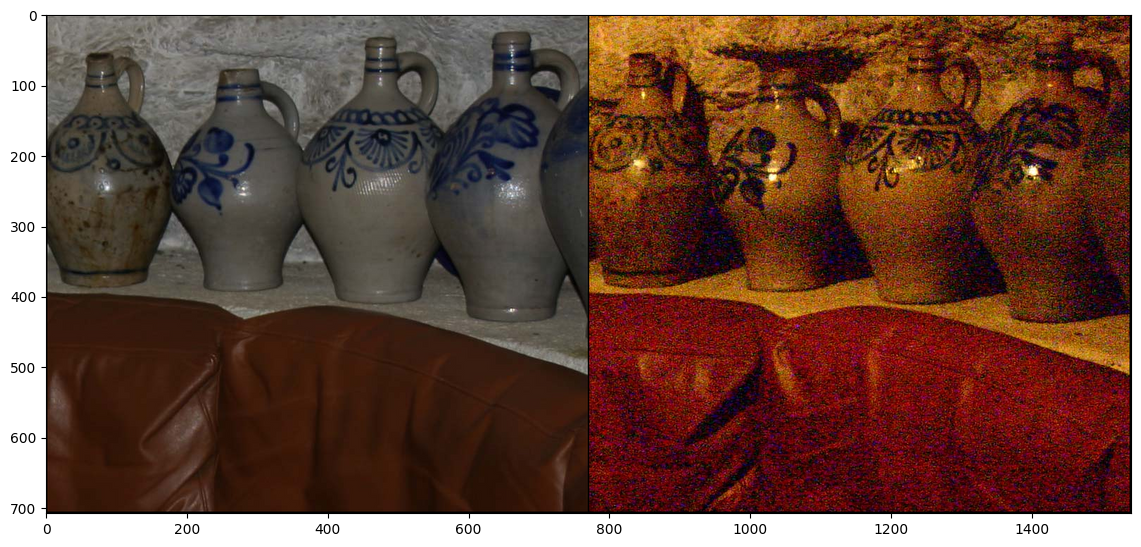

In [4]:
imgs = load_LR_HR_imgs_sr('/content/drive/MyDrive/deep-image-prior/data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')
img_flash = load_LR_HR_imgs_sr('/content/drive/MyDrive/deep-image-prior/data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_flash_np = pil_to_np(img_flash)

img_noflash = load_LR_HR_imgs_sr('/content/drive/MyDrive/deep-image-prior/data/flash_no_flash/cave01_01_noflash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_noflash_np = pil_to_np(img_noflash)

g = plot_image_grid([img_flash_np, img_noflash_np],3,12)

# Setup

In [5]:
pad = 'reflection'
OPT_OVER = 'net'

num_iter = 601
LR = 0.1
OPTIMIZER = 'adam'
reg_noise_std = 0.0
show_every = 50
figsize = 6

# We will use flash image as input
input_depth = 3
net_input =np_to_torch(img_flash_np).type(dtype)

In [6]:
net = skip(input_depth, 3, num_channels_down = [128, 128, 128, 128, 128],
                        num_channels_up   = [128, 128, 128, 128, 128],
                        num_channels_skip = [4, 4, 4, 4, 4],
                        upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear'],
                        need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

mse = torch.nn.MSELoss().type(dtype)

img_flash_var = np_to_torch(img_flash_np).type(dtype)
img_noflash_var = np_to_torch(img_noflash_np).type(dtype)

# Optimize

In [7]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()


i = 0
def closure():

    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    total_loss = mse(out, img_noflash_var)
    total_loss.backward()

    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

Sometimes the process stucks at reddish image, just run the code from the top one more time.

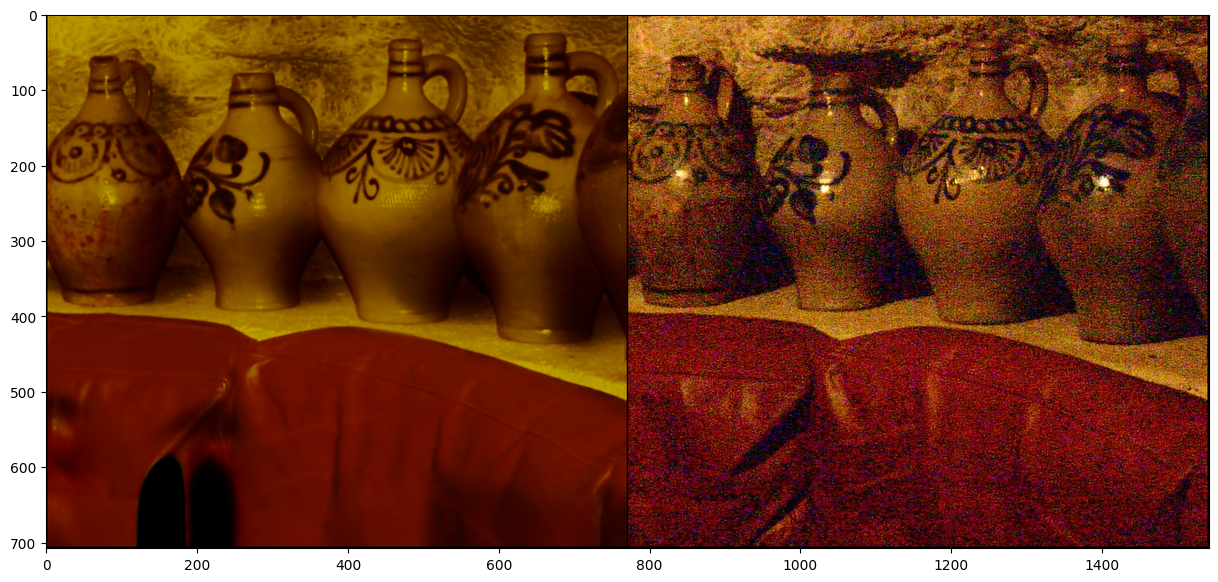

In [8]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_noflash_np], factor=13);